In [ ]:
# 모델 저장 문제, EarlyStopping 적용 문제

In [41]:
# 세션을 다시 시작한 경우 시작 위치
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import datetime
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import autokeras as ak

from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:
    # rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/ai/cnn/fish2_auto' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (5, 3) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

# ---------------------------------------------------------------------
# ---------------------------------------------------------------------

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [42]:
df = pd.read_csv('../../data/house_price_auto/train.csv')

print(type(df))
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
(1460, 81)


In [43]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [44]:
cols = df.columns.values
print(cols.shape)

(81,)


In [45]:
df.info() # object: 문자열
# Id  1460 non-null   int64: 8바이트 정수형 1460개 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [35]:
# df['PoolQC']

In [ ]:
# df.isnull().sum()

In [46]:
print(df.head(1)) # 문자를 숫자형으로 변경해야 학습 가능

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        

In [47]:
print(df['Id'].dtype)
print(df['MSZoning'].dtype) # 문자열

int64
object


In [48]:
# 데이터 전처리, 문자열 -> 정수로 변경
encoder = LabelEncoder()
for col in cols:
    if (df[col].dtype == 'object'): # 컬럼의 타입이 object인 컬럼 산출
        # print('object')
        df[col] = encoder.fit_transform(df[col]) # 0 ~ 고유한 정수로 변경

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int32  
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int32  
 6   Alley          1460 non-null   int32  
 7   LotShape       1460 non-null   int32  
 8   LandContour    1460 non-null   int32  
 9   Utilities      1460 non-null   int32  
 10  LotConfig      1460 non-null   int32  
 11  LandSlope      1460 non-null   int32  
 12  Neighborhood   1460 non-null   int32  
 13  Condition1     1460 non-null   int32  
 14  Condition2     1460 non-null   int32  
 15  BldgType       1460 non-null   int32  
 16  HouseStyle     1460 non-null   int32  
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [50]:
df['PoolQC']

0       3
1       3
2       3
3       3
4       3
5       3
6       3
7       3
8       3
9       3
10      3
11      3
12      3
13      3
14      3
15      3
16      3
17      3
18      3
19      3
20      3
21      3
22      3
23      3
24      3
25      3
26      3
27      3
28      3
29      3
30      3
31      3
32      3
33      3
34      3
35      3
36      3
37      3
38      3
39      3
40      3
41      3
42      3
43      3
44      3
45      3
46      3
47      3
48      3
49      3
50      3
51      3
52      3
53      3
54      3
55      3
56      3
57      3
58      3
59      3
60      3
61      3
62      3
63      3
64      3
65      3
66      3
67      3
68      3
69      3
70      3
71      3
72      3
73      3
74      3
75      3
76      3
77      3
78      3
79      3
80      3
81      3
82      3
83      3
84      3
85      3
86      3
87      3
88      3
89      3
90      3
91      3
92      3
93      3
94      3
95      3
96      3
97      3
98      3
99      3


In [ ]:
# df.head(5)

In [ ]:
# df.isnull().sum() # 컬럼별 결측치, 결측치도 숫자로 변경됨.

In [ ]:
# df['Alley'].isnull().sum() # 'Alley(골목)' 컬럼 결측치, 결측치도 숫자로 변경됨.

In [ ]:
# df.info()

In [ ]:
# df.fillna(0, inplace=True)

In [ ]:
# df.info()

In [ ]:
# 상관 분석, 상관이 강할수록 정확도가 높고 학습이 잘됨.
# 예) 집값이 높아지면 컴퓨터 속도가 빨라짐? 상관성이 없음으로 학습이 안됨

# X측: LotFrontage, Y측: LotFrontage -> 1, 강한상관 자기 자신
# X측: LotFrontage, Y측: SalePrice -> 0.351799, 양의 상관,
# LotFrontage(집 앞 마당): 마당(X 축)이 넓어지면 집 가격(Y 축)은 상승한다.
# X측: LotShape, Y측: SalePrice -> -0.255580, 음의 상관,
# LotShape(대지의 모양): 부지의 모양이 너무 각이 많아지면 집값이 떨어짐.

# df_corr = df.corr()
# df_corr

In [ ]:
# df_corr.sort_values('SalePrice', ascending=False, inplace=True) # SalePrice 컬럼 기준 내림차순 정렬
# df_corr['SalePrice'].head(10) # 상관계수가 가장높은 컬럼 10개 출력

In [ ]:
# print(type(df_corr['SalePrice'].head(10))) # 하나의 컬럼, 1차원과 비슷
# print(df_corr['SalePrice'].head(10).index) # 상관 관계에서 컬럼명이 index

In [ ]:
# cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
#        'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd']
# sb.pairplot(df[cols])
# plt.show()

In [51]:
Y = df.pop('SalePrice')
print(Y.shape)

(1460,)


In [52]:
Y.head(3)

0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64

In [53]:
X = df
print(X.shape)
print(X.head(1))

(1460, 80)
   Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
0   1          60         3         65.0     8450       1      2         3   

   LandContour  Utilities  LotConfig  LandSlope  Neighborhood  Condition1  \
0            3          0          4          0             5           2   

   Condition2  BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  \
0           2         0           5            7            5       2003   

   YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  \
0          2003          1         1           12           13           1   

   MasVnrArea  ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  \
0       196.0          2          4           2         2         3   

   BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  \
0             3             2         706             5           0   

   BsmtUnfSF  TotalBsmtSF  Heating  HeatingQC  CentralAir  Electrical  \
0       

In [ ]:
# 예측을 위한 회귀모델링은 표준화 생략 가능.
# scaler = StandardScaler()
# X = scaler.fit_transform(df)
# print(X[:3])
# X=df

In [54]:
# 데이터 분할, 훈련+검증: 90%(훈련: 80%, 검증: 20%), 테스트: 5%
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, shuffle=True, random_state=0)
print(x_train.shape) # 훈련+검증: 1314 건, 독립변수 9개
print(y_train.shape) # 훈련+검증: 1314 건, Target(종속변수) 1개, SalePrice
print(x_test.shape)  # 테스트: 146 건, 독립변수 9개
print(y_test.shape)  # 테스트: 146 건, Target(종속변수) 1개, SalePrice

(1387, 80)
(1387,)
(73, 80)
(73,)


In [55]:
print(type(x_train))
print(x_train.head(1))

<class 'pandas.core.frame.DataFrame'>
      Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  \
688  689          20         3         60.0     8089       1      2         3   

     LandContour  Utilities  LotConfig  LandSlope  Neighborhood  Condition1  \
688            1          0          4          0            22           2   

     Condition2  BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  \
688           2         0           2            8            6       2007   

     YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  \
688          2007          1         1            8            8           1   

     MasVnrArea  ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  \
688         0.0          2          4           2         2         3   

     BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  \
688             0             2         945             5           0   

     BsmtUnfSF  TotalBsmtSF 

In [56]:
print(y_train.head(1))

688    392000
Name: SalePrice, dtype: int64


In [ ]:
# Tensowflow
# 모델 설계, Node, Epochs, batch_size
# SEED = 0
# os.environ['PYTHONHASHSEED'] = str(SEED)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

# tf.random.set_seed(SEED) # Global seed
# np.random.seed(SEED)
# random.seed(SEED)

# model = Sequential()
# model.add(Dense(30, input_dim=8, activation='linear', name='layer1'))
# model.add(Dense(20, activation='linear', name='layer2'))
# model.add(Dense(1, activation='linear', name='layer5'))
# model.compile(optimizer=Adam(lr=0.001), loss='mse')
# model.summary()

# patience=7: 손실이 7번 늘어날때까지 훈련을 계속, 7번째 종료
# restore_best_weights=True: 가중치를 가장 오차가 적었던 경우로 저장
# es = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)

# hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True,
#                  epochs=1000, batch_size=10, callbacks=[es])

In [57]:
print(type(x_train))
print(type(y_train))
print(type(x_train.to_numpy()))
print(type(y_train.to_numpy()))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [58]:
# Autokeras
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

# AutoKeras를 사용하여 구조화된 데이터에 대한 회귀 모델을 생성합니다.
# 사용할 옵티마이저 정의 (Adam 옵티마이저, 학습률=0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # 기본값 Adam, 0.001
akmodel = ak.StructuredDataRegressor(
    optimizer=optimizer,
    max_trials=1,  # 최대 시도 횟수를 1로 설정합니다. 이는 AutoKeras가 탐색할 모델 구성의 최대 개수입니다.
    overwrite=True,  # 이전에 실행한 모델 훈련 세션을 덮어쓸지 여부를 결정합니다. True이면 이전 세션을 덮어씁니다.
    metrics=['mse']  # 모델 평가 기준으로 평균 제곱 오차(Mean Squared Error, MSE)를 사용합니다.
)

import os, datetime
# 로그 디렉토리 생성: 현재 시간을 기반으로한 포맷으로 생성됨
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# TensorBoard 콜백 정의:
# - logdir: TensorBoard가 생성된 로그 파일을 저장할 디렉토리 경로
# - histogram_freq=0: 히스토그램 시각화를 얼마나 자주 기록할지를 설정합니다.
#   여기서는 0으로 설정하여 히스토그램을 기록하지 않음을 의미합니다. Autokeras는 0을 지정해야함.
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)

# patience=7: 손실이 7번 늘어날때까지 훈련을 계속, 7번째 종료
# restore_best_weights=True: 가중치를 가장 오차가 적었던 경우로 저장
es = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# 모델을 훈련합니다. x_train은 입력 데이터, y_train은 타겟 데이터입니다.
#     batch_size=10,  # 각 훈련 스텝에서 1개의 샘플을 사용합니다. 작은 배치 크기는 더 높은 메모리 사용량과 느린 훈련 속도를 유발할 수 있습니다., 기본 32
#     validation_split=0.2,  # 전체 훈련 데이터의 20%를 검증 데이터로 사용
akmodel.fit(
    x_train.to_numpy(),
    y_train.to_numpy(),
    validation_split=0.2,  # 전체 훈련 데이터의 20%를 검증 데이터로 사용합니다. 이는 모델의 성능을 검증하기 위해 사용됩니다.
    epochs=10,  # 전체 훈련 데이터셋에 대해 모델을 5번 반복 훈련합니다. 기본 1000
    batch_size=32,  # 각 훈련 스텝에서 1개의 샘플을 사용합니다. 작은 배치 크기는 더 높은 메모리 사용량과 느린 훈련 속도를 유발할 수 있습니다., 기본 32
    callbacks=[tensorboard_callback, es])

Trial 1 Complete [00h 00m 11s]
val_loss: 2264189184.0

Best val_loss So Far: 2264189184.0
Total elapsed time: 00h 00m 11s
Epoch 1/10
44/44 [==============================] - 1s 3ms/step - loss: 38757969920.0000
Epoch 2/10
44/44 [==============================] - 0s 2ms/step - loss: 37238759424.0000
Epoch 3/10
44/44 [==============================] - 0s 2ms/step - loss: 29749284864.0000
Epoch 4/10
44/44 [==============================] - 0s 2ms/step - loss: 16013903872.0000
Epoch 5/10
44/44 [==============================] - 0s 2ms/step - loss: 8128888320.0000
Epoch 6/10
44/44 [==============================] - 0s 2ms/step - loss: 5904016384.0000
Epoch 7/10
44/44 [==============================] - 0s 3ms/step - loss: 4564935168.0000
Epoch 8/10
44/44 [==============================] - 0s 3ms/step - loss: 3820781056.0000
Epoch 9/10
44/44 [==============================] - 0s 2ms/step - loss: 3379759616.0000
Epoch 10/10
44/44 [==============================] - 0s 3ms/step - loss: 306826444

In [23]:
# Tensorboard
# %load_ext tensorboard
%reload_ext tensorboard
# %tensorboard --logdir logs
%tensorboard --logdir logs  --host localhost

Launching TensorBoard...

In [ ]:
# # 시각화
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig, loss_ax = plt.subplots()
# # plt.figure(figsize=(6,4)) # ERROR
# fig.set_size_inches(10, 5)  # 챠트 크기 설정

# # 왼쪽 y 축 설정
# loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss') # 지원 안됨
# loss_ax.set_ylim([0.0, 3613289216.0000]) # 값을 반영하여 변경 ★

# # 축 레이블 설정
# loss_ax.set_xlabel('epoch')  # 학습 횟수
# loss_ax.set_ylabel('loss')   # 오차

# loss_ax.legend(loc='upper left') # 오차 레이블 위치

# plt.show()
# # train loss: 하강하면 훈련이 정상적으로 진행되고 있음
# # val loss: 하강하면 훈련되지 않은 데이터를 대상으로 한 테스트도 정상적으로 진행됨.


In [24]:
akmodel.evaluate(x_test, y_test)

3/3 [==============================] - 1s 0s/step - loss: 6052436992.0000


6052436992.0

In [25]:
# First we export the model to a keras model
model = akmodel.export_model()

# Now, we ask for the model Sumary:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 80)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 80)               161       
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                2592      
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
try:

    model.save("House_price_auto_model", save_format="tf")

except:

    model.save("House_price_auto_model.h5")

INFO:tensorflow:Assets written to: House_price_auto_model\assets


In [60]:
# model.save('./house_price.h5')  # X
# model.save('./house_price.h5', save_format="tf")  # X
model.save("House_price_auto_model", save_format="tf")

INFO:tensorflow:Assets written to: House_price_auto_model\assets


In [61]:
# model = load_model('./house_price.h5')
from tensorflow.keras.models import load_model
model = load_model("House_price_auto_model", custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
# cols = df.columns.values
# print(cols)

In [ ]:
# 데이터 전처리, 문자열 -> 정수로 변경
# encoder = LabelEncoder()
# for col in cols:
#     if (x_test[col].dtype == 'object'): # 컬럼의 타입이 object인 컬럼 산출
#         # print('object')
#         x_test[col] = encoder.fit_transform(x_test[col]) # 0 ~ 고유한 정수로 변경

In [62]:
x_test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
529,530,20,3,NaN,32668,1,2,0,3,0,1,0,6,2,2,0,2,6,3,1957,1975,3,1,13,11,3,NaN,2,4,2,3,3,3,4,1219,5,0,816,2035,1,4,1,4,2515,0,0,2515,1,0,3,0,4,2,3,9,0,2,4,1,1975.0,1,2,484,4,4,2,0,0,200,0,0,0,3,4,4,0,3,2007,8,2
491,492,50,3,79.0,9490,1,2,3,3,0,4,0,12,0,2,0,0,6,7,1941,1950,1,1,13,14,3,0.0,3,4,1,3,3,3,1,403,4,165,238,806,1,4,1,0,958,620,0,1578,1,0,1,0,3,1,1,5,6,2,4,1,1941.0,2,1,240,4,4,2,0,0,32,0,0,0,3,2,4,0,8,2006,8,4


In [63]:
y_test_p = akmodel.predict(x_test) # 모델 사용
print(type(y_test_p))
print(y_test_p.shape) # (146, 1): 테스트 관측치(행)는 146개임, 예측값의 수 1

3/3 [==============================] - 0s 9ms/step
<class 'numpy.ndarray'>
(73, 1)


In [64]:
y_test_p = model.predict(x_test) # 모델 사용
print(type(y_test_p))
print(y_test_p.shape) # (146, 1): 테스트 관측치(행)는 146개임, 예측값의 수 1

3/3 [==============================] - 0s 139us/step
<class 'numpy.ndarray'>
(73, 1)


In [65]:
print(y_test[:3])
print(y_test_p[:3])

529    200624
491    133000
459    110000
Name: SalePrice, dtype: int64
[[142463.77]
 [ 96889.22]
 [105658.81]]


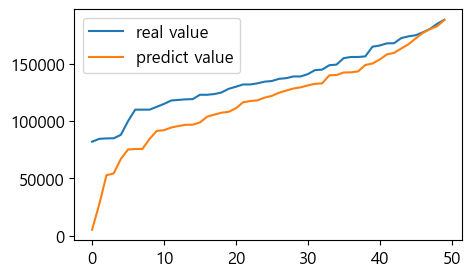

In [69]:
cnt=50
y_test = sorted(y_test)
y_test_p = sorted(y_test_p)

plt.plot(range(0,cnt), y_test[:cnt], label='real value') # 실제 집값
plt.plot(range(0,cnt), y_test_p[:cnt], label='predict value') # 예측 집값
plt.legend()
plt.show()